## Deploy Notebook Function

by: Alex Comerford (alexanderjcomerford@gmail.com)

In this notebook we will guide the user through the steps to deploying a jupyter notebook as a serverless function on openfaas.

The reason that this notebook can be majorly beneficial to several data scientists and users of jupyter notebooks is to show a method for traditional research code first implemented in a jupyter notebook to be deployed as a scalable service that can exist in a production environment

### Deploying a notebook steps

There are only three steps to deploying a notebook as a function in openfaas

1. Write your jupyter notebook (with optional [parameters](https://papermill.readthedocs.io/en/latest/usage-parameterize.html))
2. Run the `deploy_notebook` function
3. Send http requests to 

### Looking behind the curtain

In order to get a better understanding of how notebooks are being turned into 

The `deploy_notebook` specified below will use your specified notebook and add it to a docker container which bases off of the same container image used to run this development environment. This is to ensure that the notebooks being executed have as close to the same environment in which they are developed. In this container we include a script called `execute_notebook.py` which will be the main script executed by the openfaas `watchdog` to read http request data via stdin and send desired output via stdout.

`watchdog` will execute `execute_notebook.py` which uses `papermill` to execute a notebook in a desired kernel. The executed notebook will then be saved in a temporary path and the output mime-type that matches the `Http_Accept` environment variable (provided by watchdog) will be printed to stdout. This allows for a notebook to have multiple different return types to be requested.

In [130]:
import os
import json
import subprocess

In [131]:
def deploy_notebook(notebook_name, 
                    accept_parameters,
                    function_dockerfile=os.path.join(os.environ["HOME"],"work/mnt/docker/Dockerfile.func")):
    '''deploy notebook to openfaas via openfaas

    Args:
        notebook_name: path to the notebook to deploy.
        accept_parameters: boolean if notebook should accept parameters.
        function_dockerfile: path to dockerfile for functions

    Returns:
        tuple: Exit status and message
    '''
    
    ## Parse notebookname to meet OpenFaas standard naming
    funcname=os.path.splitext(
        os.path.basename(notebook_name))[0].lower().replace("_","-")

    ## Build image and return exit status
    exit_status = subprocess.check_call(["docker", "build",
                                         "-t", funcname,
                                         "-f", function_dockerfile,
                                         "--build-arg", "notebook=%s"%notebook_name,
                                         "--build-arg", "accept_parameters=%s"%str(accept_parameters),
                                         "--no-cache",
                                         "."])
    if exit_status:
        return (False, "Unable to build docker image...")

    ## Deploy image and return exit status
    exit_status = subprocess.check_call(["faas-cli", "deploy",
                                         "--image", funcname,
                                         "--name", funcname])
    if exit_status:
        return (False, "Unable to deploy docker image via faas-cli")
    
    return (True, os.path.join(os.environ["OPENFAAS_URL"], "function/%s"%funcname))

## Stdout notebooks

In the next two cells we will deploy a simple notebook that prints a string to stdout.

We will then test (with curl) that notebook as a service and print our response

In [132]:
success, out_function_url = deploy_notebook(notebook_name="./notebook_out_test.ipynb", accept_parameters=True)
success, out_function_url

(True,
 'gateway-external.openfaas.svc.cluster.local:8080/function/notebook-out-test')

In [133]:
%%time
!curl --url {out_function_url}

signal: terminated
CPU times: user 20.4 ms, sys: 12.5 ms, total: 32.9 ms
Wall time: 2.56 s


As we can see we have successfully (hopefully) executed a notebook via an http request and returned the output contents of the executed notebook.

It should be noted that even though this particular notebook only has 1 cell that prints to stdout it still took ~5 seconds to execute. With this approach the overhead of the request is not due to code execution but to the overhead of starting the correct jupyter kernel, writing the notebook to disk, and parsing/sending output through stdout. Fortunately this overhead remains (nearly) constant and can be thought of as negligable for longer based computation

## Sending parameters to notebook services

An additional feature of `watchdog` and `execute_notebook.py` is that json passed as the payload to a POST request gets translated to paramaters for the notebook ([language dependent](https://papermill.readthedocs.io/en/latest/reference/papermill-translators.html))

In the next cell we will deploy a new notebook that takes parameters and will produce new outputs based on those paramaters. Feel free to edit the json paramaters in the `curl` command to interact with it yourself!

In [88]:
success, multiple_out_function_url = deploy_notebook(notebook_name="./notebook_multiple_outputs.ipynb", accept_parameters=True)
success, multiple_out_function_url

 Here we are going to define a small utility lambda function in order to convert a dictionary of paramaters into a specially formatted string so inline jupyter shell commands can correctly read single quotes `'` and double quotes `"`

In [195]:
fmt_json_string = lambda j:json.dumps(j).replace("\"","\\\"").replace("\'","\'")

Now we will define a dictionary of paramaters to input into the specific notebook deployed above, then use the `fmt_json_string` to format the string appropriately to use with `curl` in the jupyter notebook

In [198]:
## define parameters
params = {
    "TEST":"'Hello!'"
}

## Without parameters
!curl -s --url  "{multiple_out_function_url}"

## With parameters
!curl -s --data "{fmt_json_string(params)}" \
         --url  "{multiple_out_function_url}"

The TEST variable is THIS IS A DEFAULT TEST STRING

The TEST variable is 'Hello!'



## Parameters + return mime-types

Now that we have demonstrated sending parameters to a notebook service and getting a new result based on those parameters, we can now introduce a new feature of `watchdog` and `execute_notebook.py` which is return mime-types. This feature allows the user to specify the `Accept` header in their request which will then be used to parse whatever mime-type was provided in the executed output notebook to be returned to the user.

To demonstrate this we will use the notebook we passed parameters to before except we will specify our `Accept` header in the `curl` request to be of type `image/png` which will return a `base64` representation of a `png` image. 

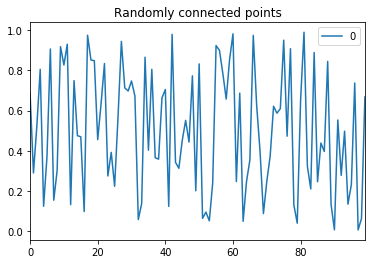

CPU times: user 86.1 ms, sys: 29.5 ms, total: 116 ms
Wall time: 6.77 s


In [203]:
%%time

## define parameters
params = {
    "NUM_POINTS":100
}

## Get a new plot updating the number of points we want
!curl -s -o /tmp/notebook-multiple-outputs \
      -H "Accept: image/png" \
      --data "{fmt_json_string(params)}" \
      --url  "{multiple_out_function_url}"

## Decode the b64 plot to a png
!cat /tmp/notebook-multiple-outputs | base64 -d > /tmp/decoded.png

## Display the decoded image
from IPython.display import display, Image
display(Image(filename='/tmp/decoded.png'))

## Cosine Similarity in scala example

In the next cell we will deploy a notebook written in scala as a function and get the cosine similarity as an output

In [36]:
deploy_notebook(notebook_name="./notebook_cosine_similarity_scala.ipynb", 
                accept_parameters=True)

CPU times: user 3.84 ms, sys: 6.34 ms, total: 10.2 ms
Wall time: 17.2 s


True

In [18]:
%%time

!curl -s \
      --data '{"VECTOR_A":[1,-2,3,1,-1,1,-1,5,5,5,-5,5, 5],  \
               "VECTOR_B":[1,1, 4,1, 1,1, 1,5,5,5, 5,5,-5]}' \
      -H "Accept: text/plain" \
      $OPENFAAS_URL/function/notebook-cosine-similarity-scala

0.3588483640679464
CPU times: user 177 ms, sys: 37 ms, total: 214 ms
Wall time: 12.2 s


## Mandelbrot Set in Clojure!

In the next few cells we will deploy a notebook written in clojure to generate an ascii version of the mandelbrot set

In [46]:
%%time
deploy_notebook(notebook_name="./notebook_mandelbrot_clojure.ipynb", 
                accept_parameters=False)

CPU times: user 8.61 ms, sys: 6.96 ms, total: 15.6 ms
Wall time: 20.5 s


True

In [48]:
%%time

## Get a new plot updating the number of points we want
!curl -s \
      -H "Accept: text/plain" \
      $OPENFAAS_URL/function/notebook-mandelbrot-clojure

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"""""""""""""""-----"""""""""",,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,""""""""""""""----:/~@:::---""""""""",,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,"""""""""""""""------::/($~|#~:----""""""""",,,,,,,,,,
,,,,,,,,,,,,,,,,,"""""""""""""""-------:::/(*|~~~|(/::-----"""""""",,,,,,,,
,,,,,,,,,,,,,""""""""""""""--------::::///($~~~~~~~|(/::::----"""""",,,,,,,
,,,,,,,,,,""""""""""""---------:::/**#***|$#~~~~~~%$||((//(~:---""""",,,,,,
,,,,,,"""""""""""-----------:::://*@~~~~~~~~~~~~~~~~~~~#@~~~~/:--"""""",,,,
,,,"""""""""""----:::::::::::///(|~@~~~~~~~~~~~~~~~~~~~~~~~@(/:---""""",,,,
,"""""""""-----::/|$(//(*((((((*|%~~~~~~~~~~~~~~~~~~~~~~~~~%$$/:--"""""",,,
"""""""------:::/(*#~~~@~~%~$||$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*/:---"""""",,
""""------::::/((*#@~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$/:---"""""",,
"---:::::////(*@%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*/::---"""""",,
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$*//::---"""""",,
"---:::::///

## Singular Vector Decomposition in R

In [8]:
%%time
deploy_notebook(notebook_name="./notebook_svd_R.ipynb", 
                accept_parameters=False)

CPU times: user 399 µs, sys: 4.24 ms, total: 4.64 ms
Wall time: 12.8 s


True

In [9]:
%%time

!curl -s \
      --data '{\
                "INPUT_MATRIX":[[1,-2,3,1],   \
                                [-1,1,-1,5,], \
                                [5,5,-5,5]],  \
              }' \
      -H "Accept: text/plain" \
      $OPENFAAS_URL/function/notebook-svd-r

{
  "d": [13.0112, 0.8419, 9.9099e-17],
  "u": [
    [-0.4177, -0.8117, 0.4082],
    [-0.5647, -0.1201, -0.8165],
    [-0.7118, 0.5716, 0.4082]
  ],
  "v": [
    [-0.283, 0.7873, -0.3741],
    [-0.4132, 0.3595, 0.797],
    [-0.5434, -0.0683, -0.4717],
    [-0.6737, -0.4962, 0.0488]
  ]
} 
CPU times: user 56.9 ms, sys: 30.3 ms, total: 87.3 ms
Wall time: 4.14 s
